In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

Load Travis' table

In [206]:
tb = pd.read_csv("All_KepStars_For_Ruth_McQuillan_Analysis_grJHK.csv")
print(np.shape(tb))

(177039, 20)


In [207]:
tb.head()

KIC            source_id       plx      plxe    g_final  g_final_err  \
0  757076  2050233807328471424  0.001524  0.000048  12.350957     0.020306   
1  757099  2050233601176543104  0.002708  0.000027  13.704047     0.020015   
2  757137  2050230543159814656  0.001753  0.000025  10.052258     0.027917   
3  757280  2050230611879323904  0.001214  0.000022  12.132906     0.020044   
4  757450  2050231848829944320  0.001199  0.000026  15.894970     0.020246   

  g_prov_final    r_final  r_final_err r_prov_final    Jmag  e_Jmag    Hmag  \
0  g_kic_fixed  11.588633     0.020419  r_kic_fixed  10.126   0.018   9.667   
1  g_kis_fixed  13.115469     0.020004  r_kis_fixed  11.656   0.018  11.193   
2  g_kic_fixed   9.099976     0.035228  r_kic_fixed   7.467   0.027   6.853   
3  g_kic_fixed  11.825413     0.020076  r_kic_fixed  10.852   0.018  10.662   
4  g_kis_fixed  15.152545     0.020081  r_kis_fixed  13.665   0.021  13.262   

   e_Hmag    Kmag  e_Kmag  [Fe/H]i n_[Fe/H]i        _RA       _DE  
0   0.019   9.559   0.017   -0.083       KIC  291.03873  36.59813  
1   0.019  11.094   0.018   -0.208       KIC  291.04306  36.59381  
2   0.018   6.722   0.017   -0.079       KIC  291.05588  36.55995  
3   0.018  10.627   0.018   -0.231       KIC  291.09540  36.56494  
4   0.025  13.118   0.029    0.229       SPE  291.13760  36.57738

Crossmatch with the McQuillan catalogue.

In [208]:
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
mc.head()

KID  Teff  logg    Mass    Prot  Prot_err      Rper    LPH       w  DC  \
0   892376  3813  4.47  0.4699   1.532     0.007   7306.69  0.823  0.4503   0   
1  1026146  4261  4.57  0.6472  14.891     0.120  11742.56  1.405  0.7229   0   
2  1026474  4122  4.56  0.5914   1.569     0.006  30471.80  1.204  0.6061   0   
3  1162635  3760  4.77  0.4497  15.678     0.019  10207.47  0.978  0.5445   1   
4  1164102  4045  4.62  0.5606  31.496     0.474   5139.74  0.568  0.3939   0   

  Flag  
0  ---  
1  ---  
2  ---  
3  ---  
4  ---

In [209]:
print(np.shape(mc))

(34030, 11)


In [210]:
mctb1 = pd.merge(tb, mc, left_on="KIC", right_on="KID", how="inner")
print(np.shape(tb), np.shape(mc), np.shape(mctb1))

(177039, 20) (34030, 11) (30086, 31)


Add Teffs from Travis' catalog.

In [211]:
with fits.open("hlsp_kg-radii_kepler-gaia_multi_all_multi_v1_star-cat.fits") as data:
    tb2 = pd.DataFrame(data[1].data, dtype="float64")
    
tb_teff = pd.DataFrame(dict({"berger_teff": tb2.Teff, "berger_teff_err": tb2.Teff_err,
                             "KIC": tb2.KIC_ID}))

In [212]:
mctb = pd.merge(mctb1, tb_teff, left_on="KID", right_on="KIC", how="inner")
print(np.shape(mctb), np.shape(mctb1), np.shape(tb_teff))

(30044, 34) (30086, 31) (177911, 3)


Download Gaia catalog

In [218]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

Merge the Gaia catalog and the McQuillan sample.

In [219]:
gaia_mc_nan = pd.merge(mctb, gaia, left_on="KID", right_on="kepid", how="left")
print(np.shape(mctb), np.shape(gaia), np.shape(gaia_mc_nan))

(30044, 39) (197090, 101) (30334, 140)


Remove NaNs.

In [220]:
def mM(m, D):
    return 5 - 5*np.log10(D) + m

abs_G = mM(gaia_mc_nan.phot_g_mean_mag.values, 1./(gaia_mc_nan.parallax.values*1e-3))
gaia_mc_nan["abs_G"] = abs_G

gaia_mc_nan["abs_g"] = mM(gaia_mc_nan.g_final.values, 1./(gaia_mc_nan.parallax.values*1e-3))
gaia_mc_nan["bprp"] = gaia_mc_nan.phot_bp_mean_mag.values - gaia_mc_nan.phot_rp_mean_mag.values

m = np.isfinite(gaia_mc_nan.g_final.values - gaia_mc_nan.Kmag.values)
m &= np.isfinite(gaia_mc_nan.abs_g.values)
m &= np.isfinite(gaia_mc_nan.Av.values) * np.isfinite(gaia_mc_nan.Av_errp.values)
m &= np.isfinite(gaia_mc_nan.Av_errm.values) * np.isfinite(gaia_mc_nan.Av_std.values)
m &= np.isfinite(gaia_mc_nan.abs_G.values)
m &= np.isfinite(gaia_mc_nan.bprp.values)

gaia_mc = gaia_mc_nan.iloc[m]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  



Calculate Av

In [213]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 24.555 s
  pix_info:   0.551 s
   samples:  11.713 s
      best:   5.839 s
       nan:   0.207 s
      sort:   6.022 s
       idx:   0.224 s


In [248]:
coords = SkyCoord(gaia_mc.ra.values*units.deg, gaia_mc.dec.values*units.deg,
                  distance=(1./(gaia_mc.parallax.values*1e-3))*units.pc, frame='galactic')

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

In [249]:
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)
print(np.shape(gaia_mc), np.shape(Av))

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

(30055, 146) (30055,)


In [250]:
# mctb["Av_flags"] = flags
gaia_mc["ebv"] = ebv[:, 1]  # The median ebv value.
gaia_mc["Av"] = Av
gaia_mc["Av_errp"] = Av_errp
gaia_mc["Av_errm"] = Av_errm
gaia_mc["Av_std"] = Av_std

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Calculate dereddened photometry.

In [251]:
from tools import getDust

AG, Abp, Arp = [np.empty(len(gaia_mc)) for i in range(3)]
for i in trange(len(gaia_mc.phot_g_mean_mag.values)):
    AGs, Abps, Arps = getDust(gaia_mc.phot_g_mean_mag.values[i], gaia_mc.phot_bp_mean_mag.values[i],
                              gaia_mc.phot_rp_mean_mag.values[i], gaia_mc.ebv.values[i])
    AG[i], Abp[i], Arp[i] = AGs, Abps, Arps

100%|██████████| 30055/30055 [03:05<00:00, 162.13it/s]


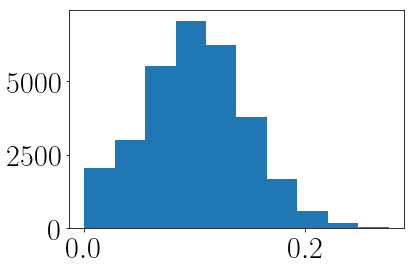

In [247]:
plt.hist(Arp);

In [252]:
gaia_mc["bp_dered"] = gaia_mc.phot_bp_mean_mag.values - Abp
gaia_mc["rp_dered"] = gaia_mc.phot_rp_mean_mag.values - Arp
gaia_mc["bprp_dered"] = bp_dered - rp_dered
gaia_mc["G_dered"] = gaia_mc.phot_g_mean_mag.values - AG

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

Plot stars on the CMD.

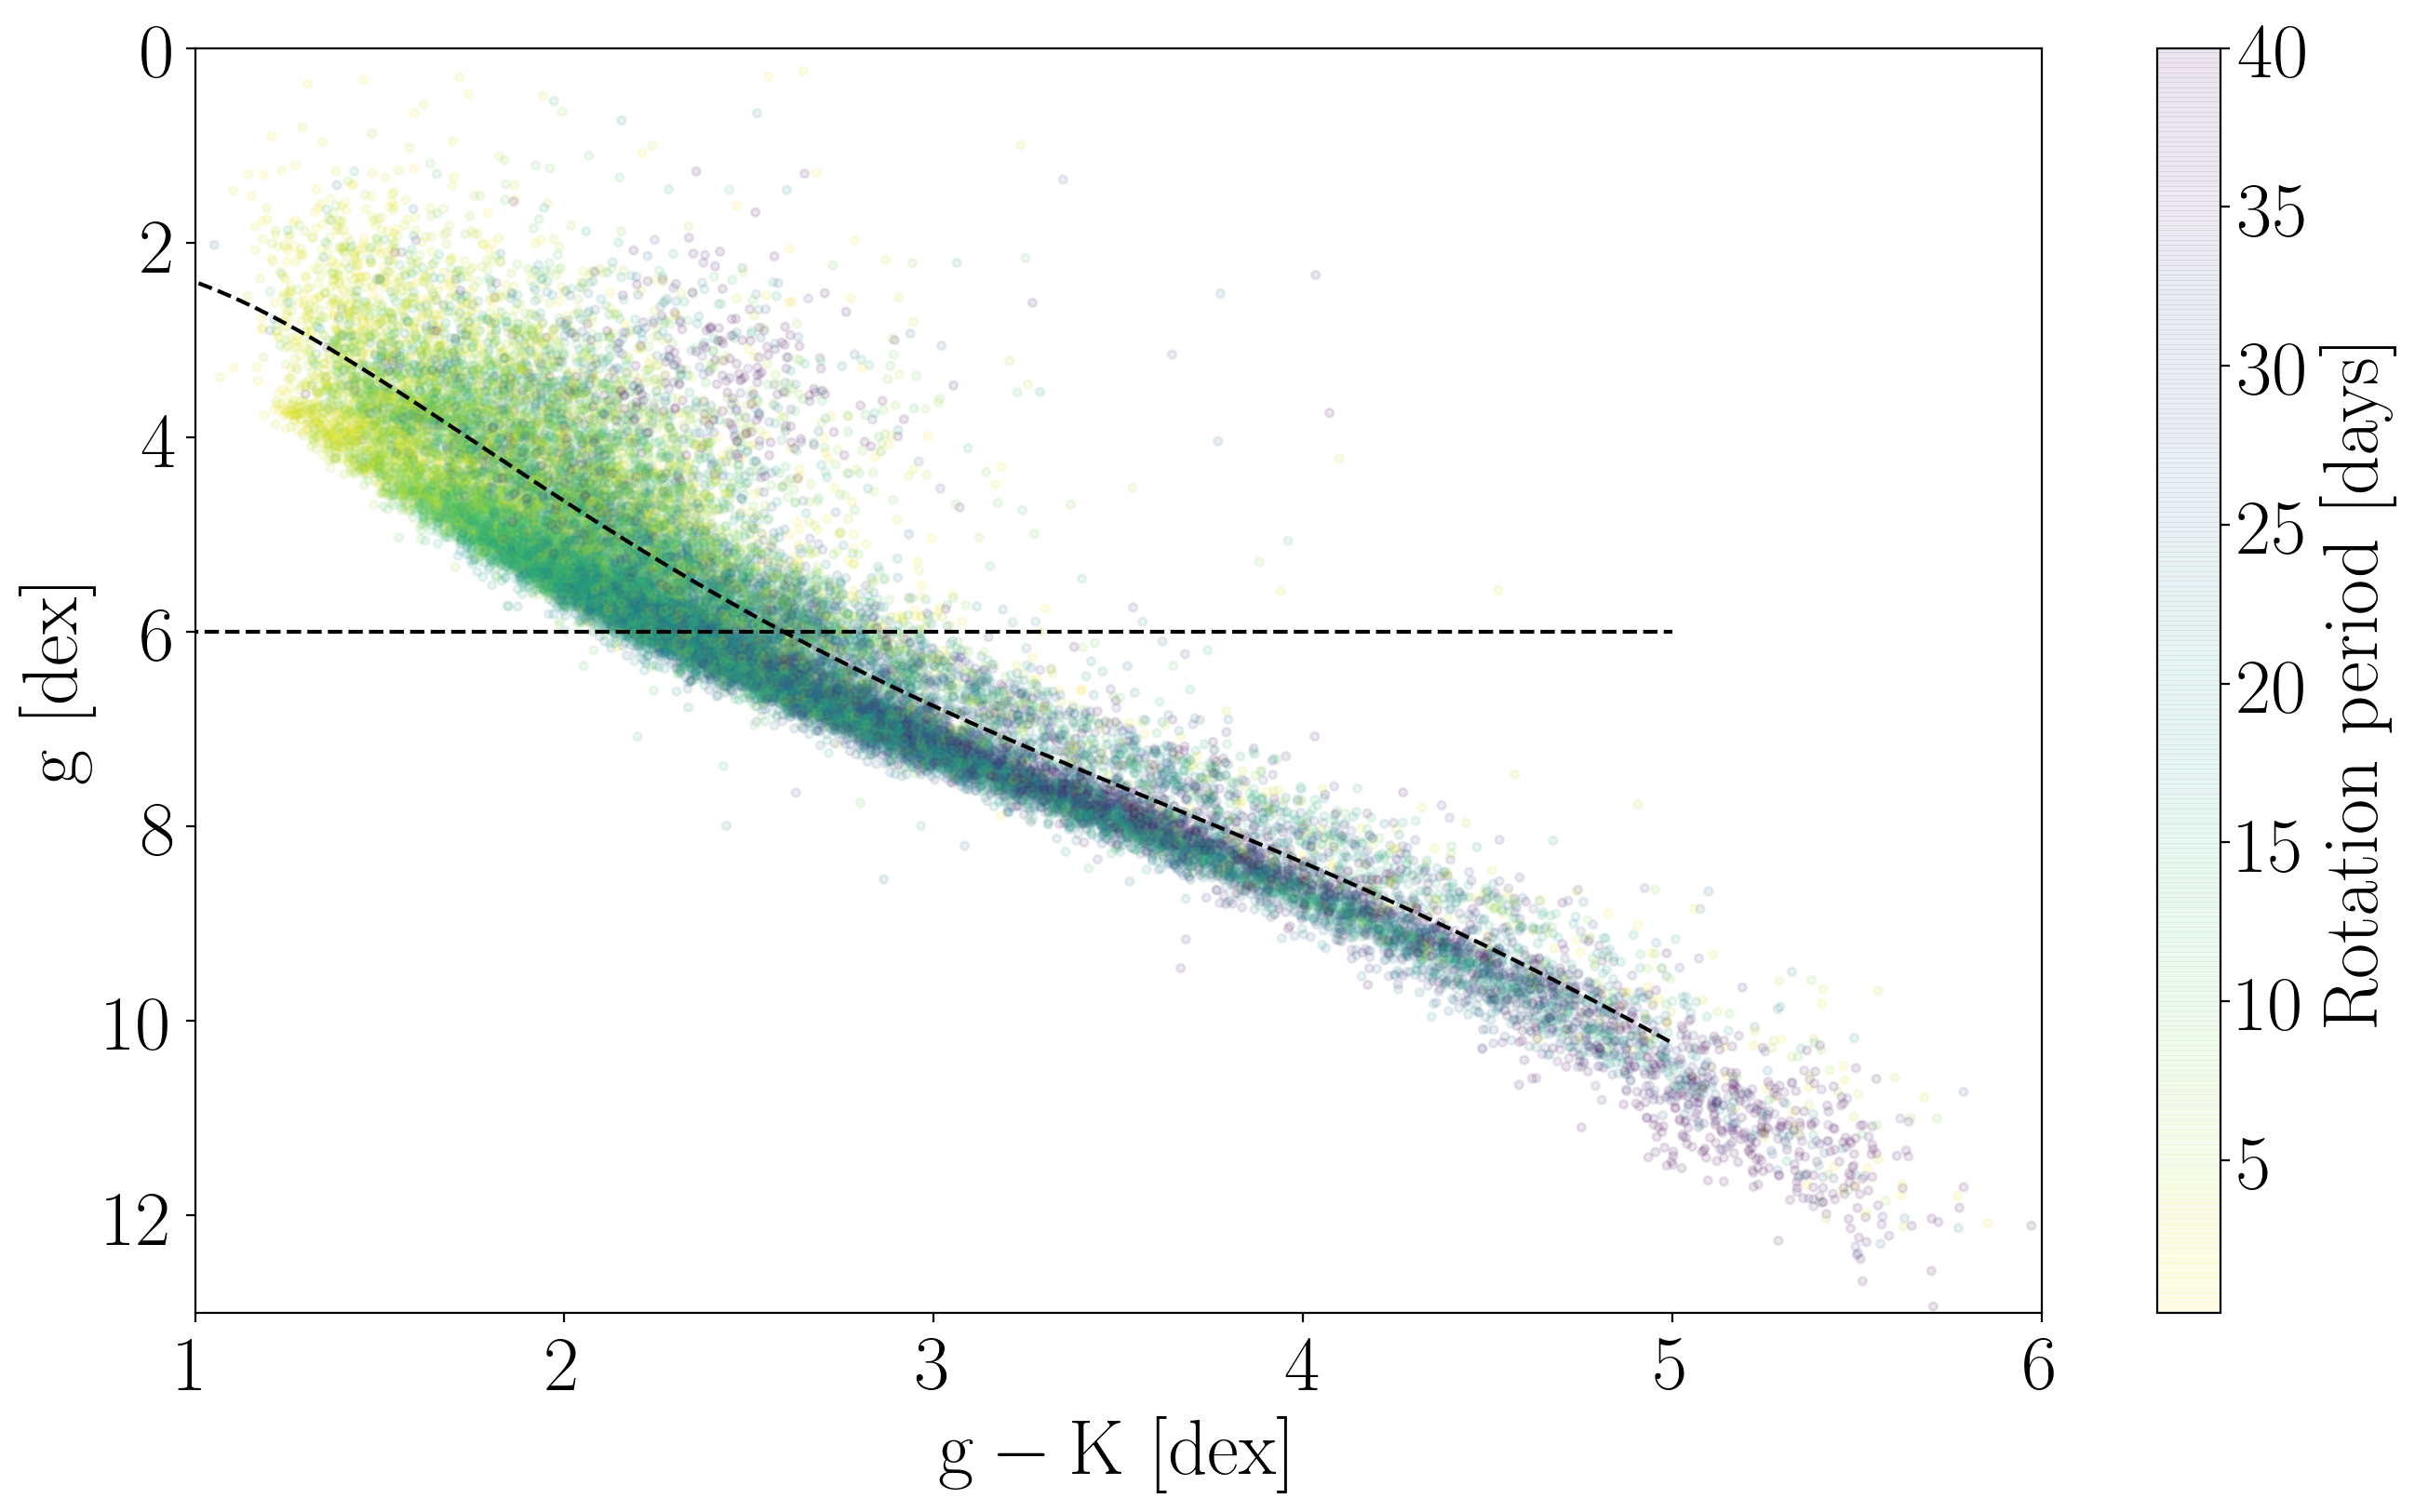

In [300]:
import scipy.optimize as spo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)


plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gaia_mc.g_final - gaia_mc.Kmag, gaia_mc.abs_g,
            c=gaia_mc.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True)
plt.xlabel("$\mathrm{g-K~[dex]}$")
plt.ylabel("$\mathrm{g~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(13, 0)
plt.xlim(1, 6);

x = gaia_mc.g_final.values - gaia_mc.Kmag.values
y = mM(gaia_mc.g_final.values, 1./(gaia_mc.parallax.values*1e-3))

AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, y))

minb, maxb, extra = 0, 5, .15
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "k--")
plt.plot(xs, np.ones_like(xs)*6, "k--")
plt.savefig("paper/CMD_cuts.pdf")

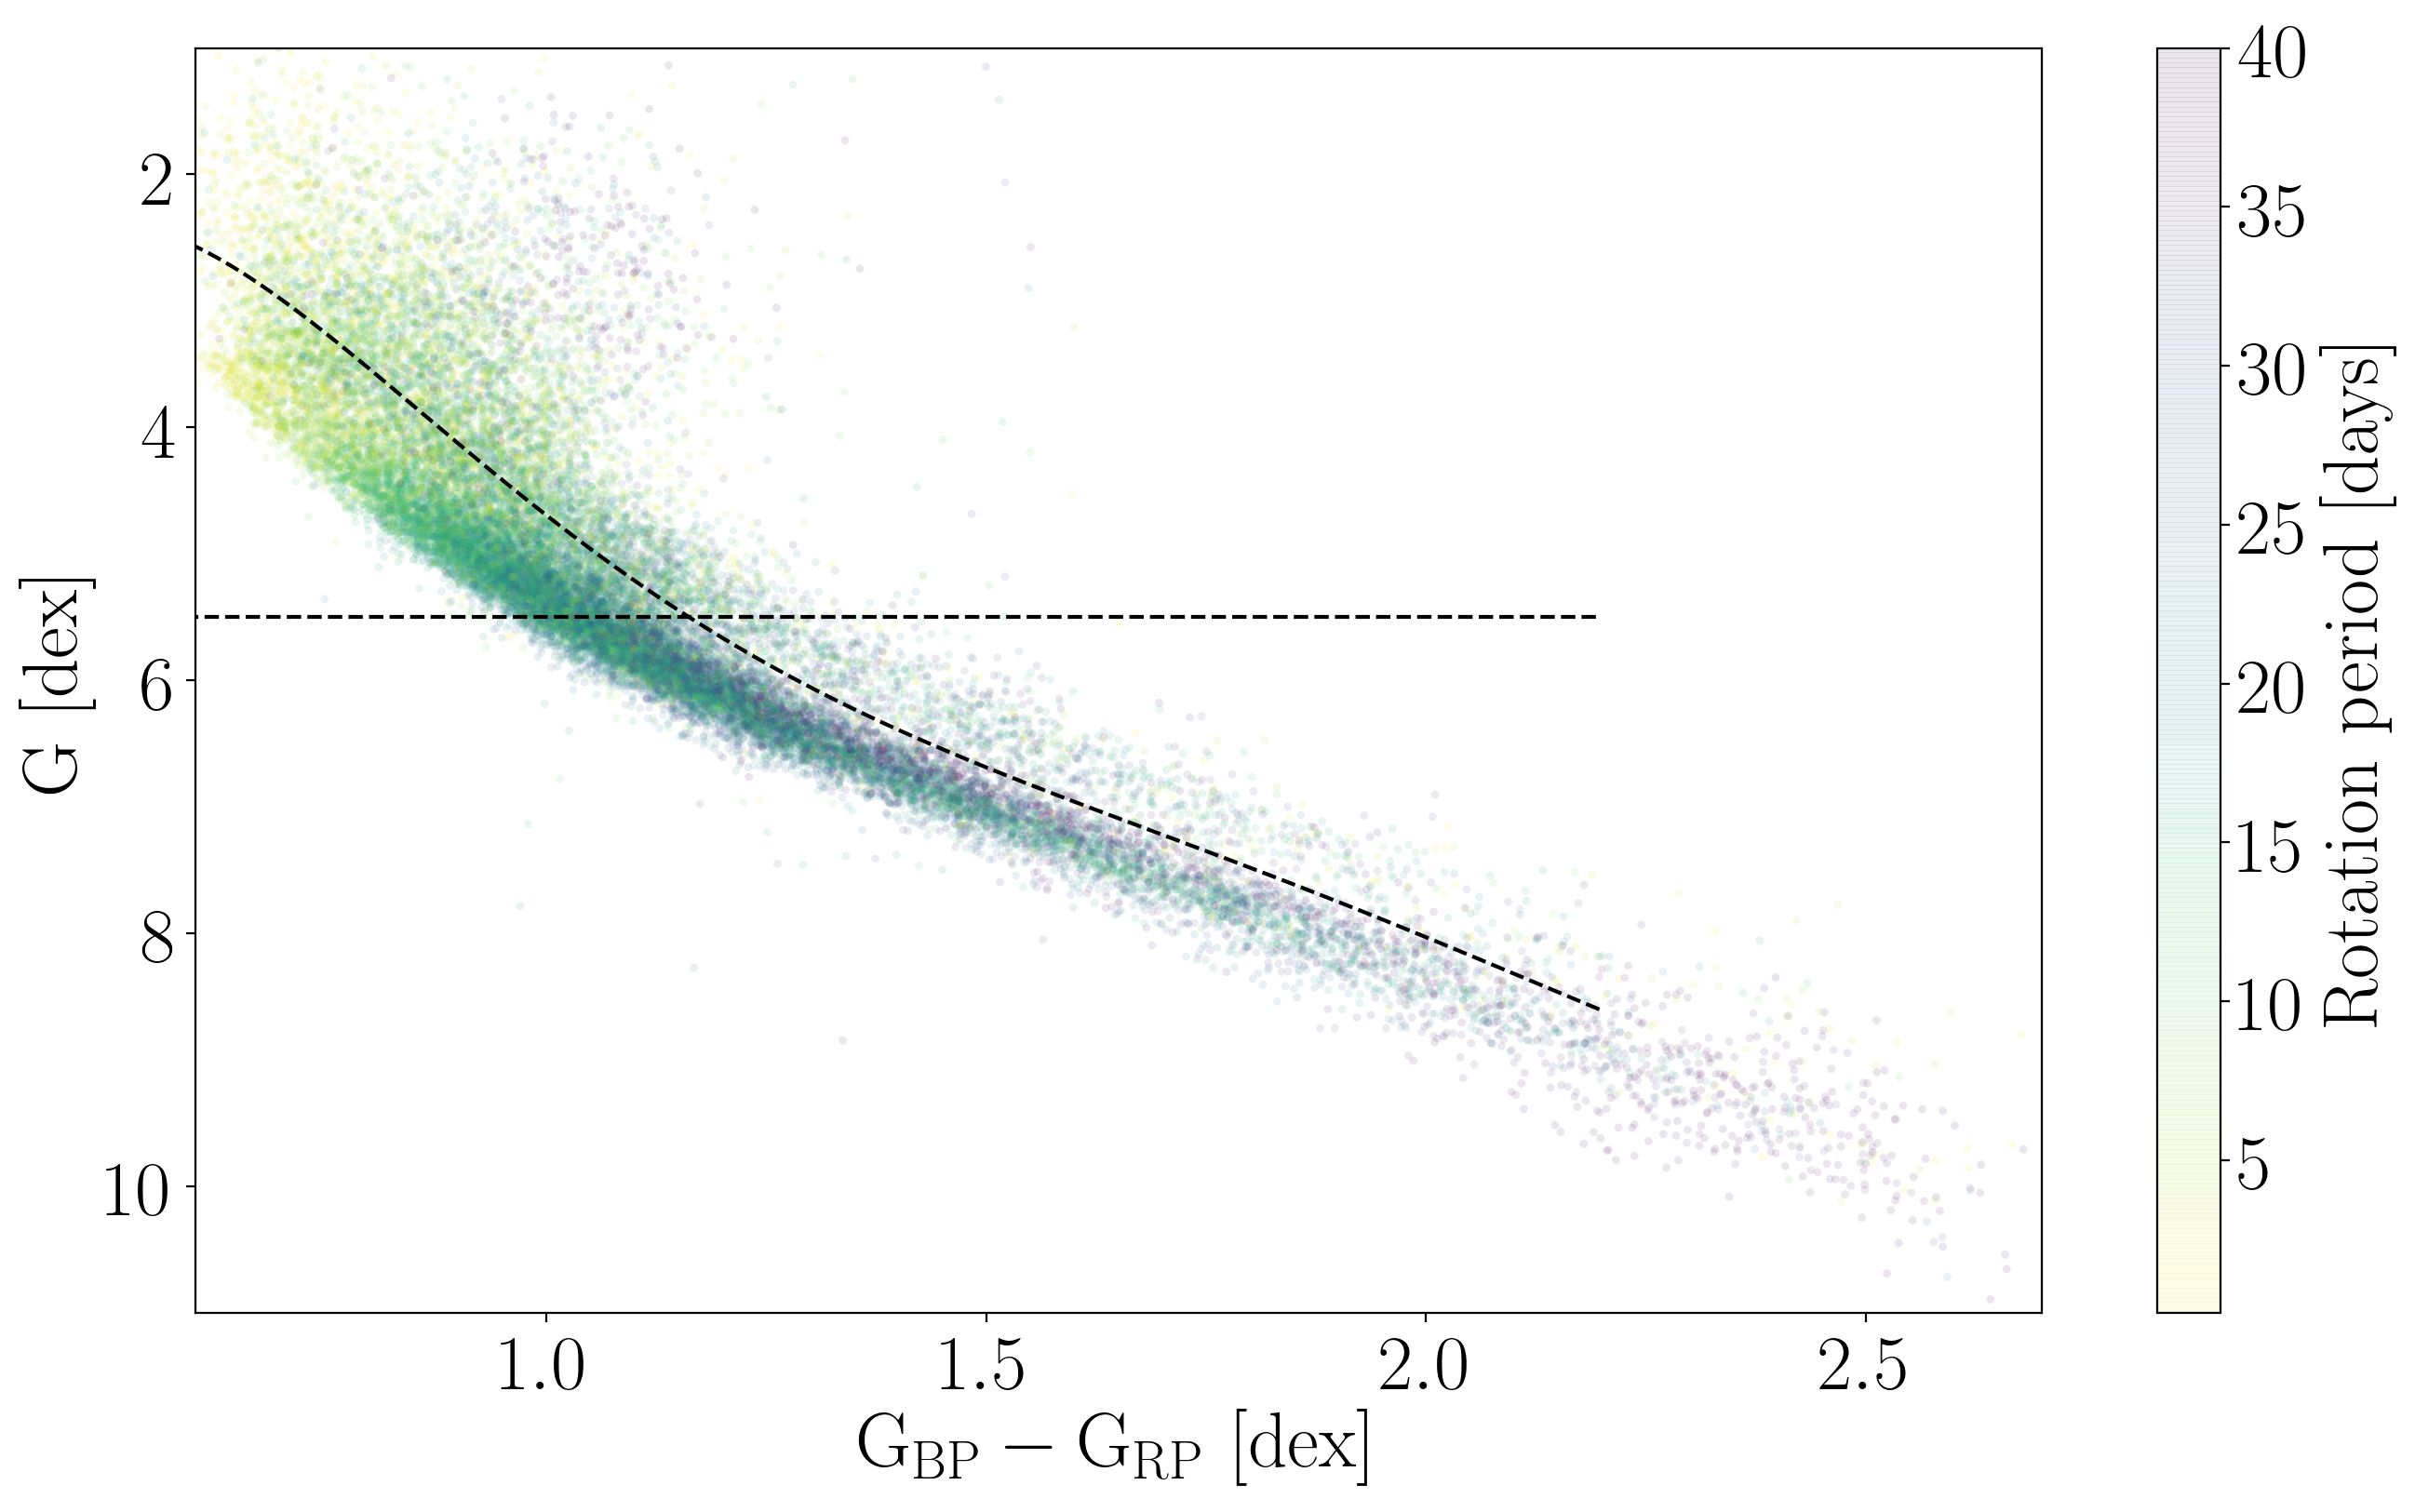

In [301]:
abs_G = mM(gaia_mc.G_dered.values, 1./(gaia_mc.parallax.values*1e-3))

plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gaia_mc.phot_bp_mean_mag - gaia_mc.phot_rp_mean_mag, gaia_mc.abs_G,
# plt.scatter(gaia_mc.bp_dered - gaia_mc.rp_dered, abs_G,
            c=gaia_mc.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.6, 2.7);

x = gaia_mc.bprp.values
y = gaia_mc.abs_G.values

AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, y))

minb, maxb, extra = 0, 2.2, .2
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "k--")
subcut = 5.5
plt.plot(xs, np.ones_like(xs)*subcut, "k--")
plt.savefig("paper/CMD_cuts.pdf")

Cut the binaries

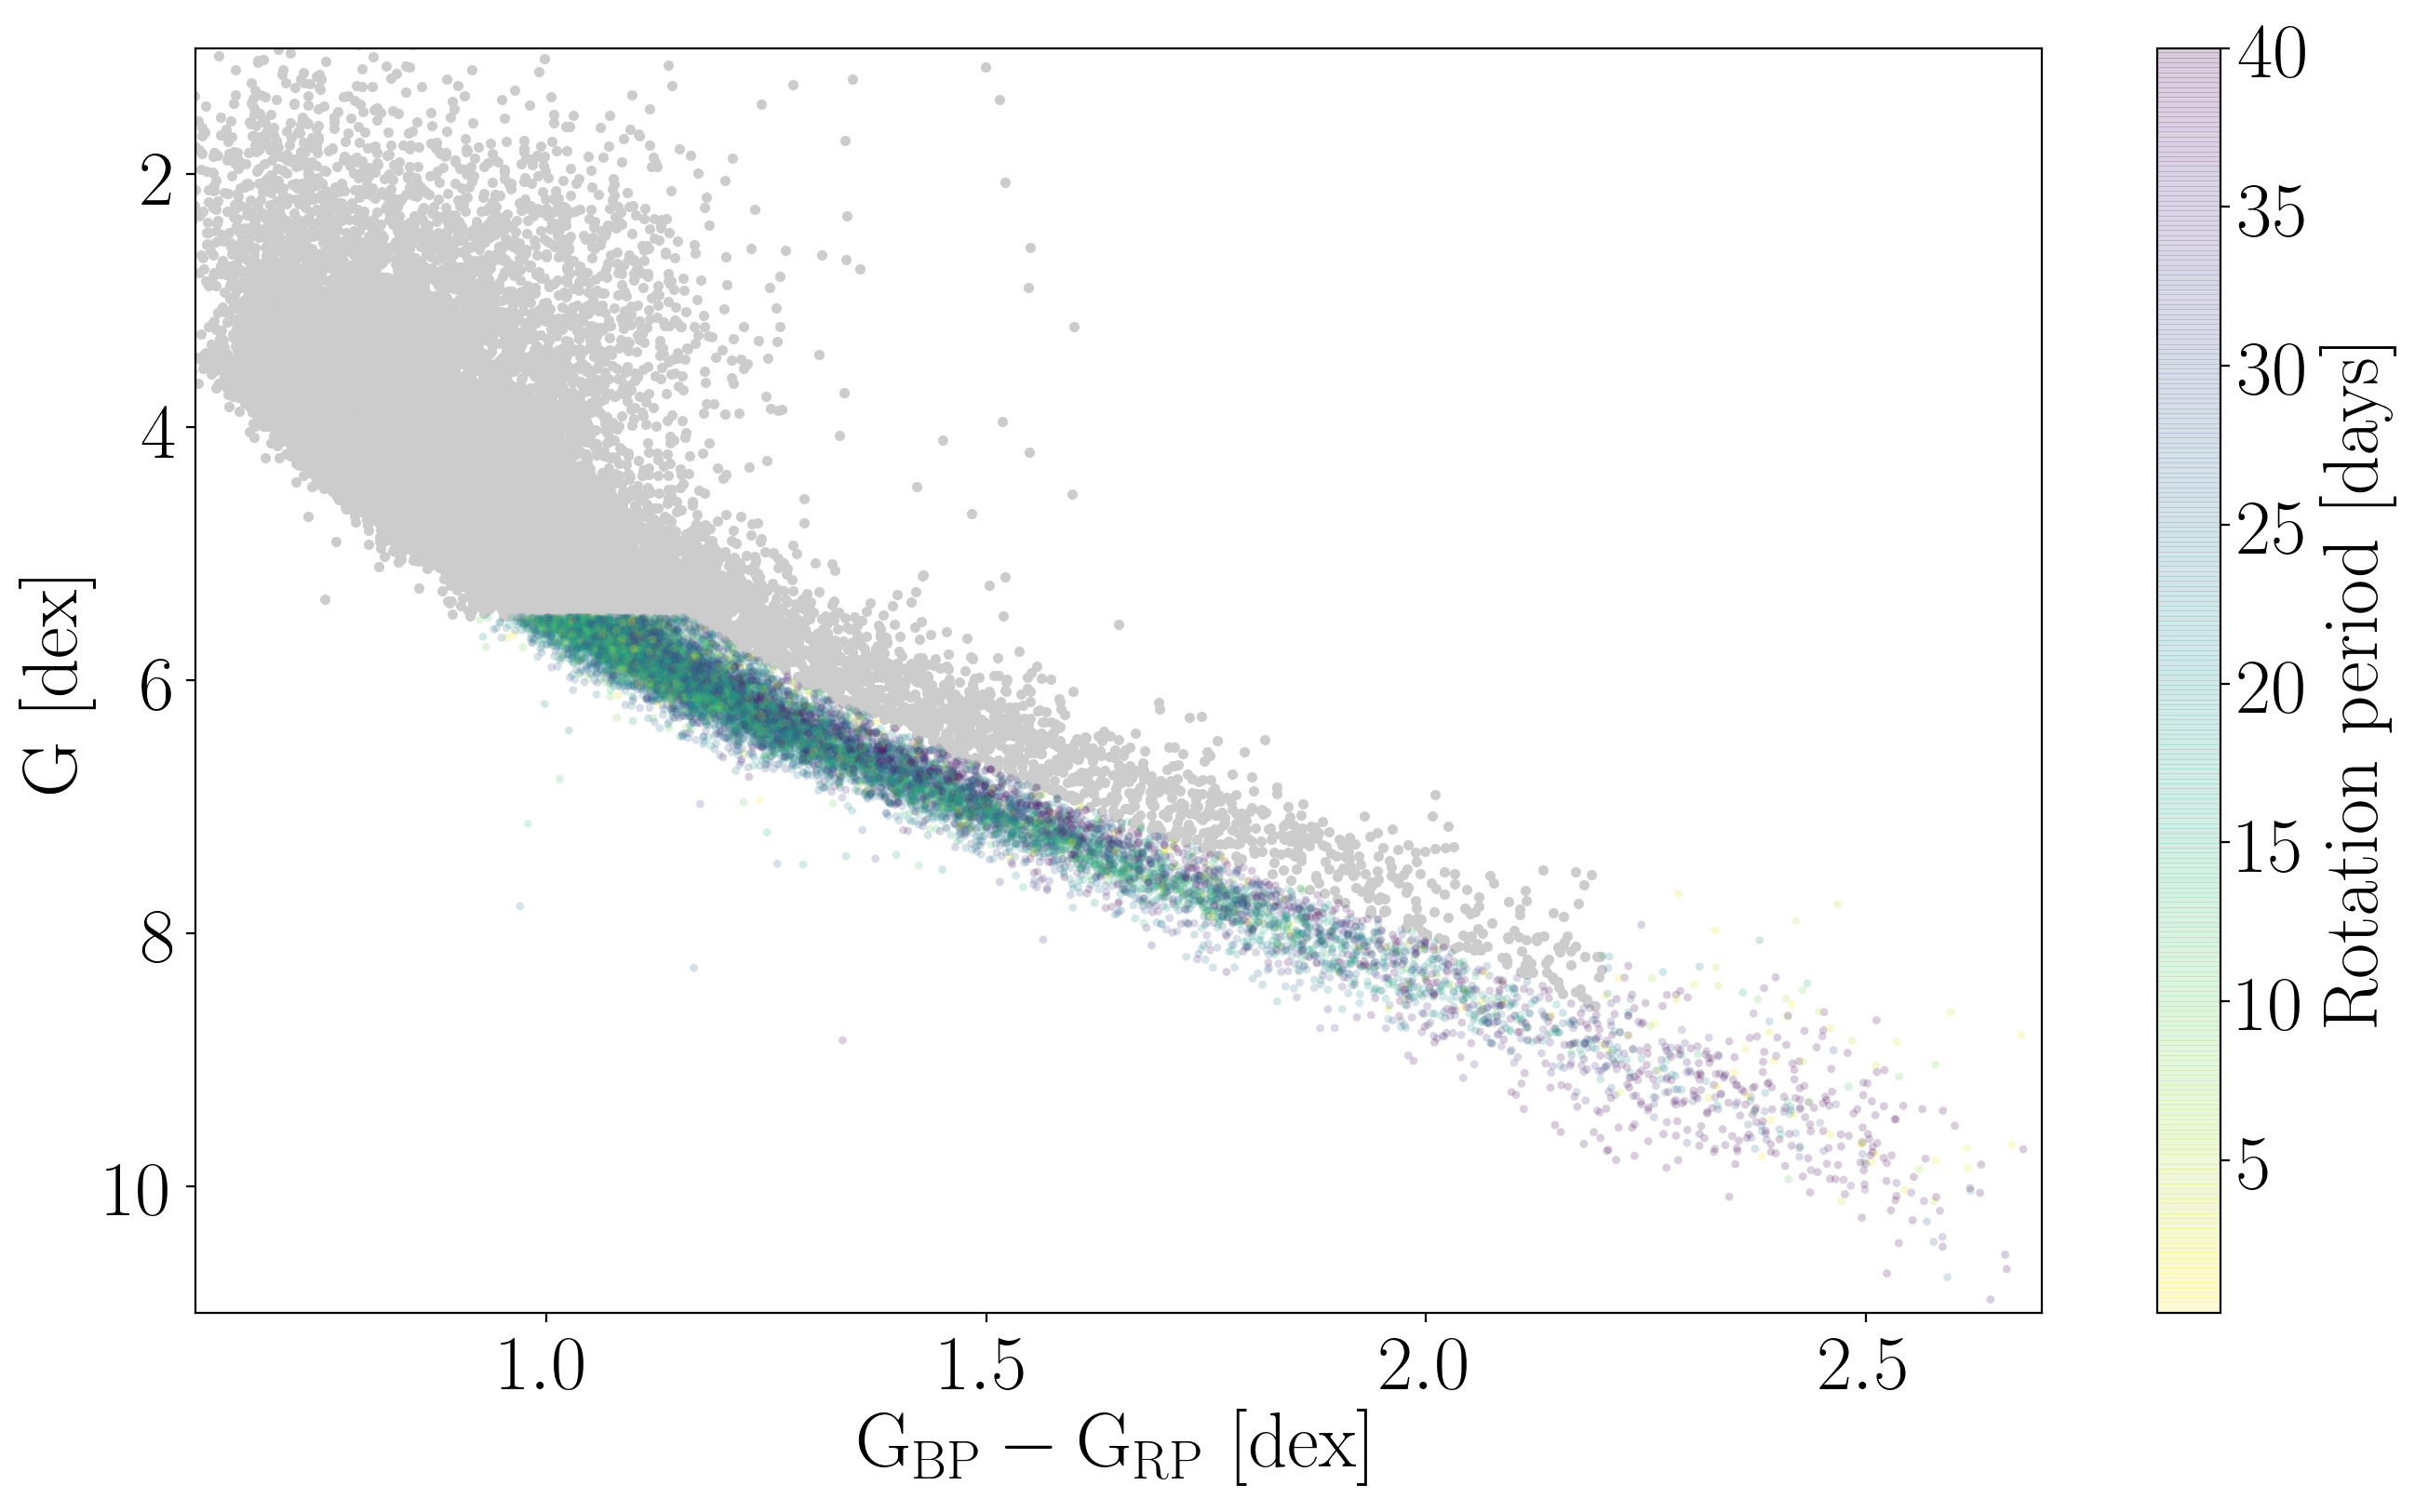

In [302]:
m = (minb < x) * (x < maxb)
m &= (y < np.polyval(w, x) - extra) + (subcut > y)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gaia_mc.bprp[m], gaia_mc.abs_G[m], ".", c=".8", zorder=0)
# plt.scatter(df_finite.g_final[m] - df_finite.Kmag[m],
#             mM(df_finite.g_final[m], 1./df_finite.plx[m]),
#             c=df_finite.Prot[m], s=10, alpha=.03, cmap="viridis_r", vmax=40, zorder=1)
plt.scatter(gaia_mc.bprp[~m], gaia_mc.abs_G[~m],
            c=gaia_mc.Prot[~m], s=10, alpha=.2, cmap="viridis_r", vmax=40, zorder=1,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.6, 2.7);

In [303]:
# import read_mist_models
# iso = read_mist_models.ISO(
#     "/Users/rangus/projects/astro-viz/data/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

Load isochrones

In [304]:
# from tqdm import tqdm
# ages, G, bp, rp = [[] for i in range(4)]
# for i, a in enumerate(tqdm(np.log10(np.linspace(.1, 13.8, 100)*1e9))):
    
#     age_ind = iso.age_index(a) #returns the index for the desired age
#     age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
#     g = iso.isos[age_ind]["Gaia_G_DR2Rev"]
#     _rp = iso.isos[age_ind]["Gaia_RP_DR2Rev"]
#     _bp = iso.isos[age_ind]["Gaia_BP_DR2Rev"]
    
#     ages.append(age)
#     G.append(g)
#     rp.append(_rp)
#     bp.append(_bp)

# ages = np.array([i for j in ages for i in j])
# G = np.array([i for j in G for i in j])
# bp = np.array([i for j in bp for i in j])
# rp = np.array([i for j in rp for i in j])

Flag is zero for subgiants and visual binaries, one for single stars.

In [305]:
flag = np.zeros(len(gaia_mc))
flag[~m] = np.ones(len(flag[~m])) 
gaia_mc["flag"] = flag

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



In [306]:
df = gaia_mc.iloc[~m]
df.to_csv("single_MS_stars.csv")

Download Gaia catalog

In [307]:
# import astropy.utils as au
# from astropy.io import fits

# gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

# with fits.open(gaia_url) as data:
#     gaia = pd.DataFrame(data[1].data, dtype="float64")

Merge the Gaia catalog and the McQuillan sample.

In [308]:
# gaia_mc = pd.merge(df, gaia, left_on="KID", right_on="kepid", how="inner")
# print(np.shape(mc), np.shape(gaia), np.shape(gaia_mc))

Calculate very simple gyro ages for these stars.

In [309]:
from stardate.lhf import age_model

logages = []
for i, p in enumerate(df.Prot.values):
    logages.append(age_model(np.log10(p), df.phot_bp_mean_mag.values[i] -
                             df.phot_rp_mean_mag.values[i]))

df["log_age"] = np.array(logages)
df["age"] = (10**np.array(logages))*1e-9

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':



In [310]:
import read_mist_models
iso = read_mist_models.ISO(
    "/Users/rangus/projects/astro-viz/data/MIST_v1.2_vvcrit0.0_UBVRIplus/" \
    "MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

Reading in: /Users/rangus/projects/astro-viz/data/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso


100%|██████████| 4/4 [00:00<00:00, 2043.76it/s]

1.0
5.623413251903491
10.0
14.125375446227613


(0.6, 1.7)

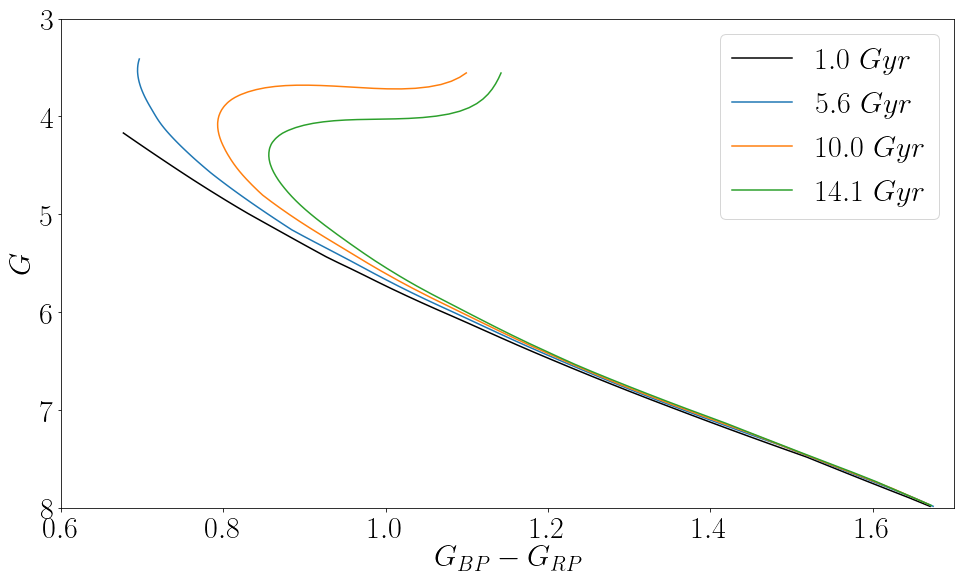

In [311]:
from tqdm import tqdm
tmin, tmax = 4000, 6200
Lmin, Lmax = -1.2, .5

def get_properties(iso, tmin, tmax, Lmin, Lmax):
    teffs, Ls, ages, G, bp, rp = [[] for i in range(6)]
    for i, a in enumerate(tqdm(np.log10(np.linspace(1, 14, 4)*1e9))):
    
        age_ind = iso.age_index(a) #returns the index for the desired age
        logTeff = iso.isos[age_ind]['log_Teff']
        logL = iso.isos[age_ind]['log_L']
        age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
        g = iso.isos[age_ind]["Gaia_G_DR2Rev"]
        _rp = iso.isos[age_ind]["Gaia_RP_DR2Rev"]
        _bp = iso.isos[age_ind]["Gaia_BP_DR2Rev"]
    
        teff = 10**logTeff
        m = (teff < tmax) * (tmin < teff)
        m &= (logL < Lmax) * (Lmin < logL)

        Ls.append(logL[m])
        teffs.append(teff[m])
        ages.append(age[m])
        G.append(g[m])
        rp.append(_rp[m])
        bp.append(_bp[m])
    
    return teffs, Ls, ages, G, bp, rp

teffs, Ls, ages, G, bp, rp = get_properties(iso, tmin, tmax, Lmin, Lmax)

plt.figure(figsize=(16, 9))
colors = ["k", "C0", "C1", "C2"]
for i in range(len(G)):
    plt.plot(bp[i]-rp[i], G[i], color=colors[i], ls="-",
             label="${0:.1f}~Gyr$".format(ages[i][0]), zorder=0)
    print(ages[i][0])
    
plt.legend()
plt.ylabel('$G$')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylim(8, 3)
plt.xlim(.6, 1.7)

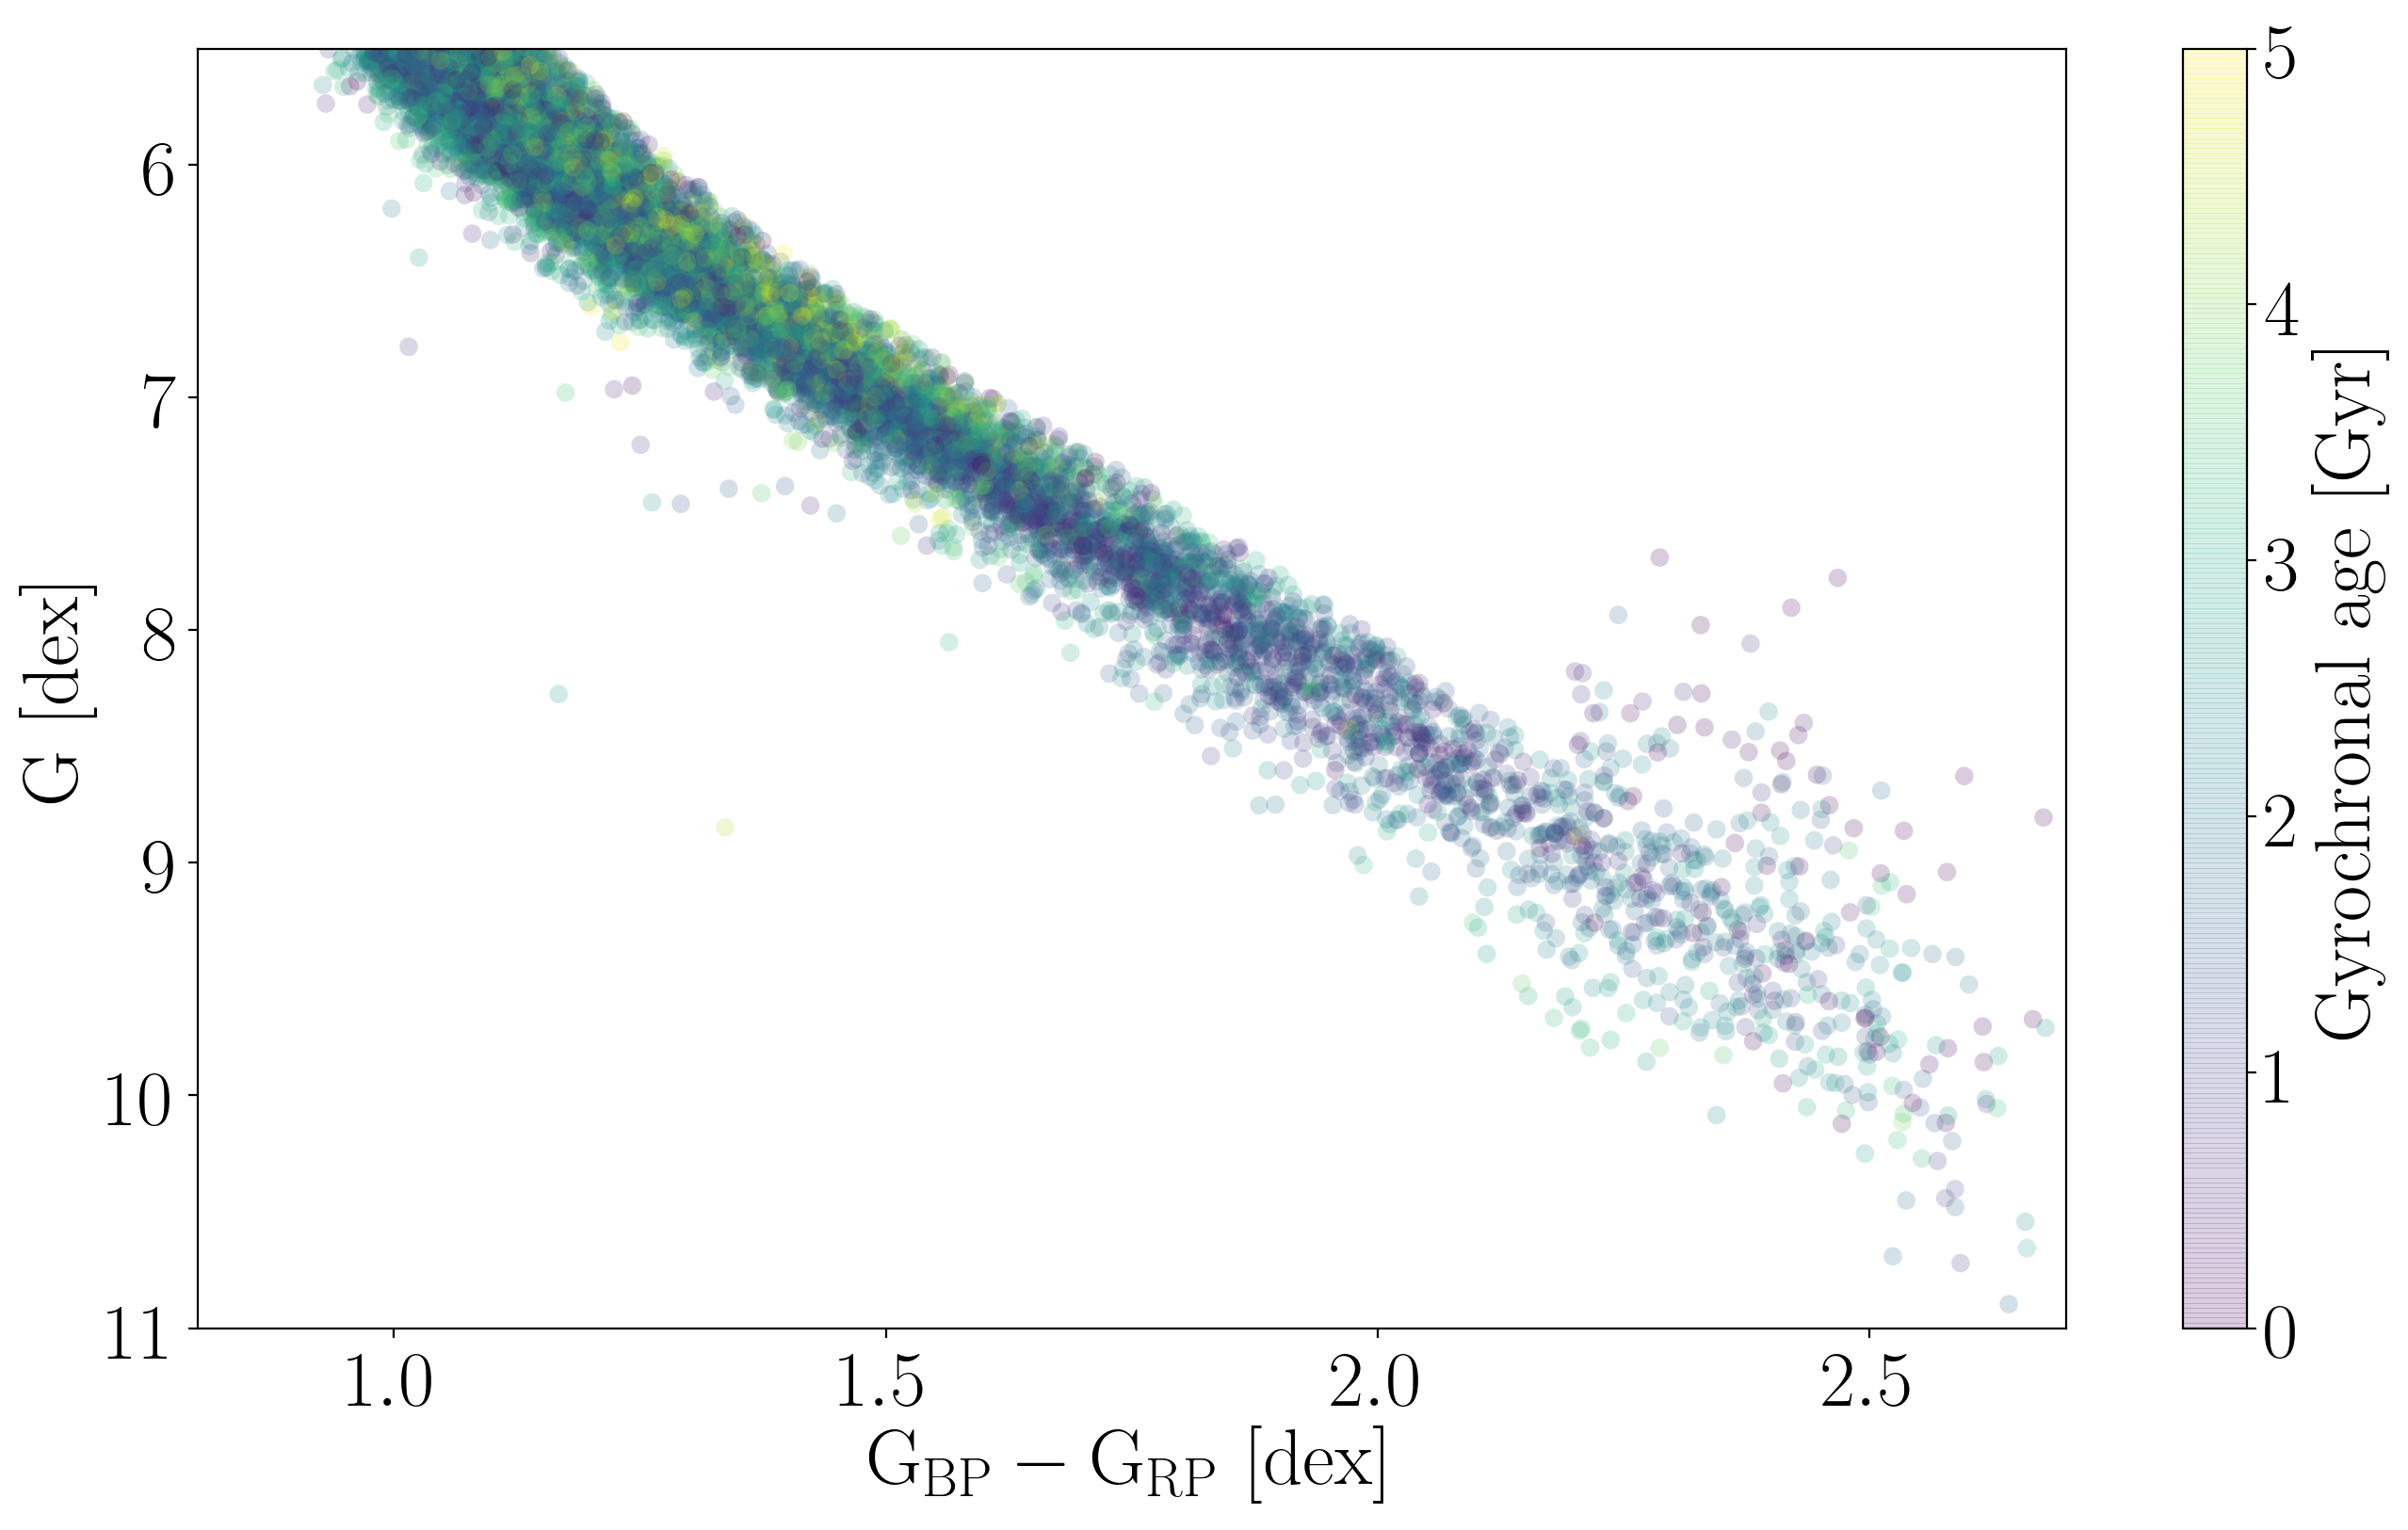

In [316]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.abs_G, c=df.age,
# plt.scatter(df.bprp_dered, df.abs_G, c=df.age,
            vmin=0, vmax=5, s=50, alpha=.2, cmap="viridis", rasterized=True, edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Gyrochronal~age~[Gyr]}$")
plt.ylim(11, 5.5)
plt.xlim(.8, 2.7);

# colors = ["k", "C0", "C1", "C2"]
# for i in range(len(G)):
#     plt.plot(bp[i]-rp[i], G[i], color=colors[i], ls="-",
#              zorder=1)

# plt.legend()
plt.savefig("paper/age_gradient.pdf")

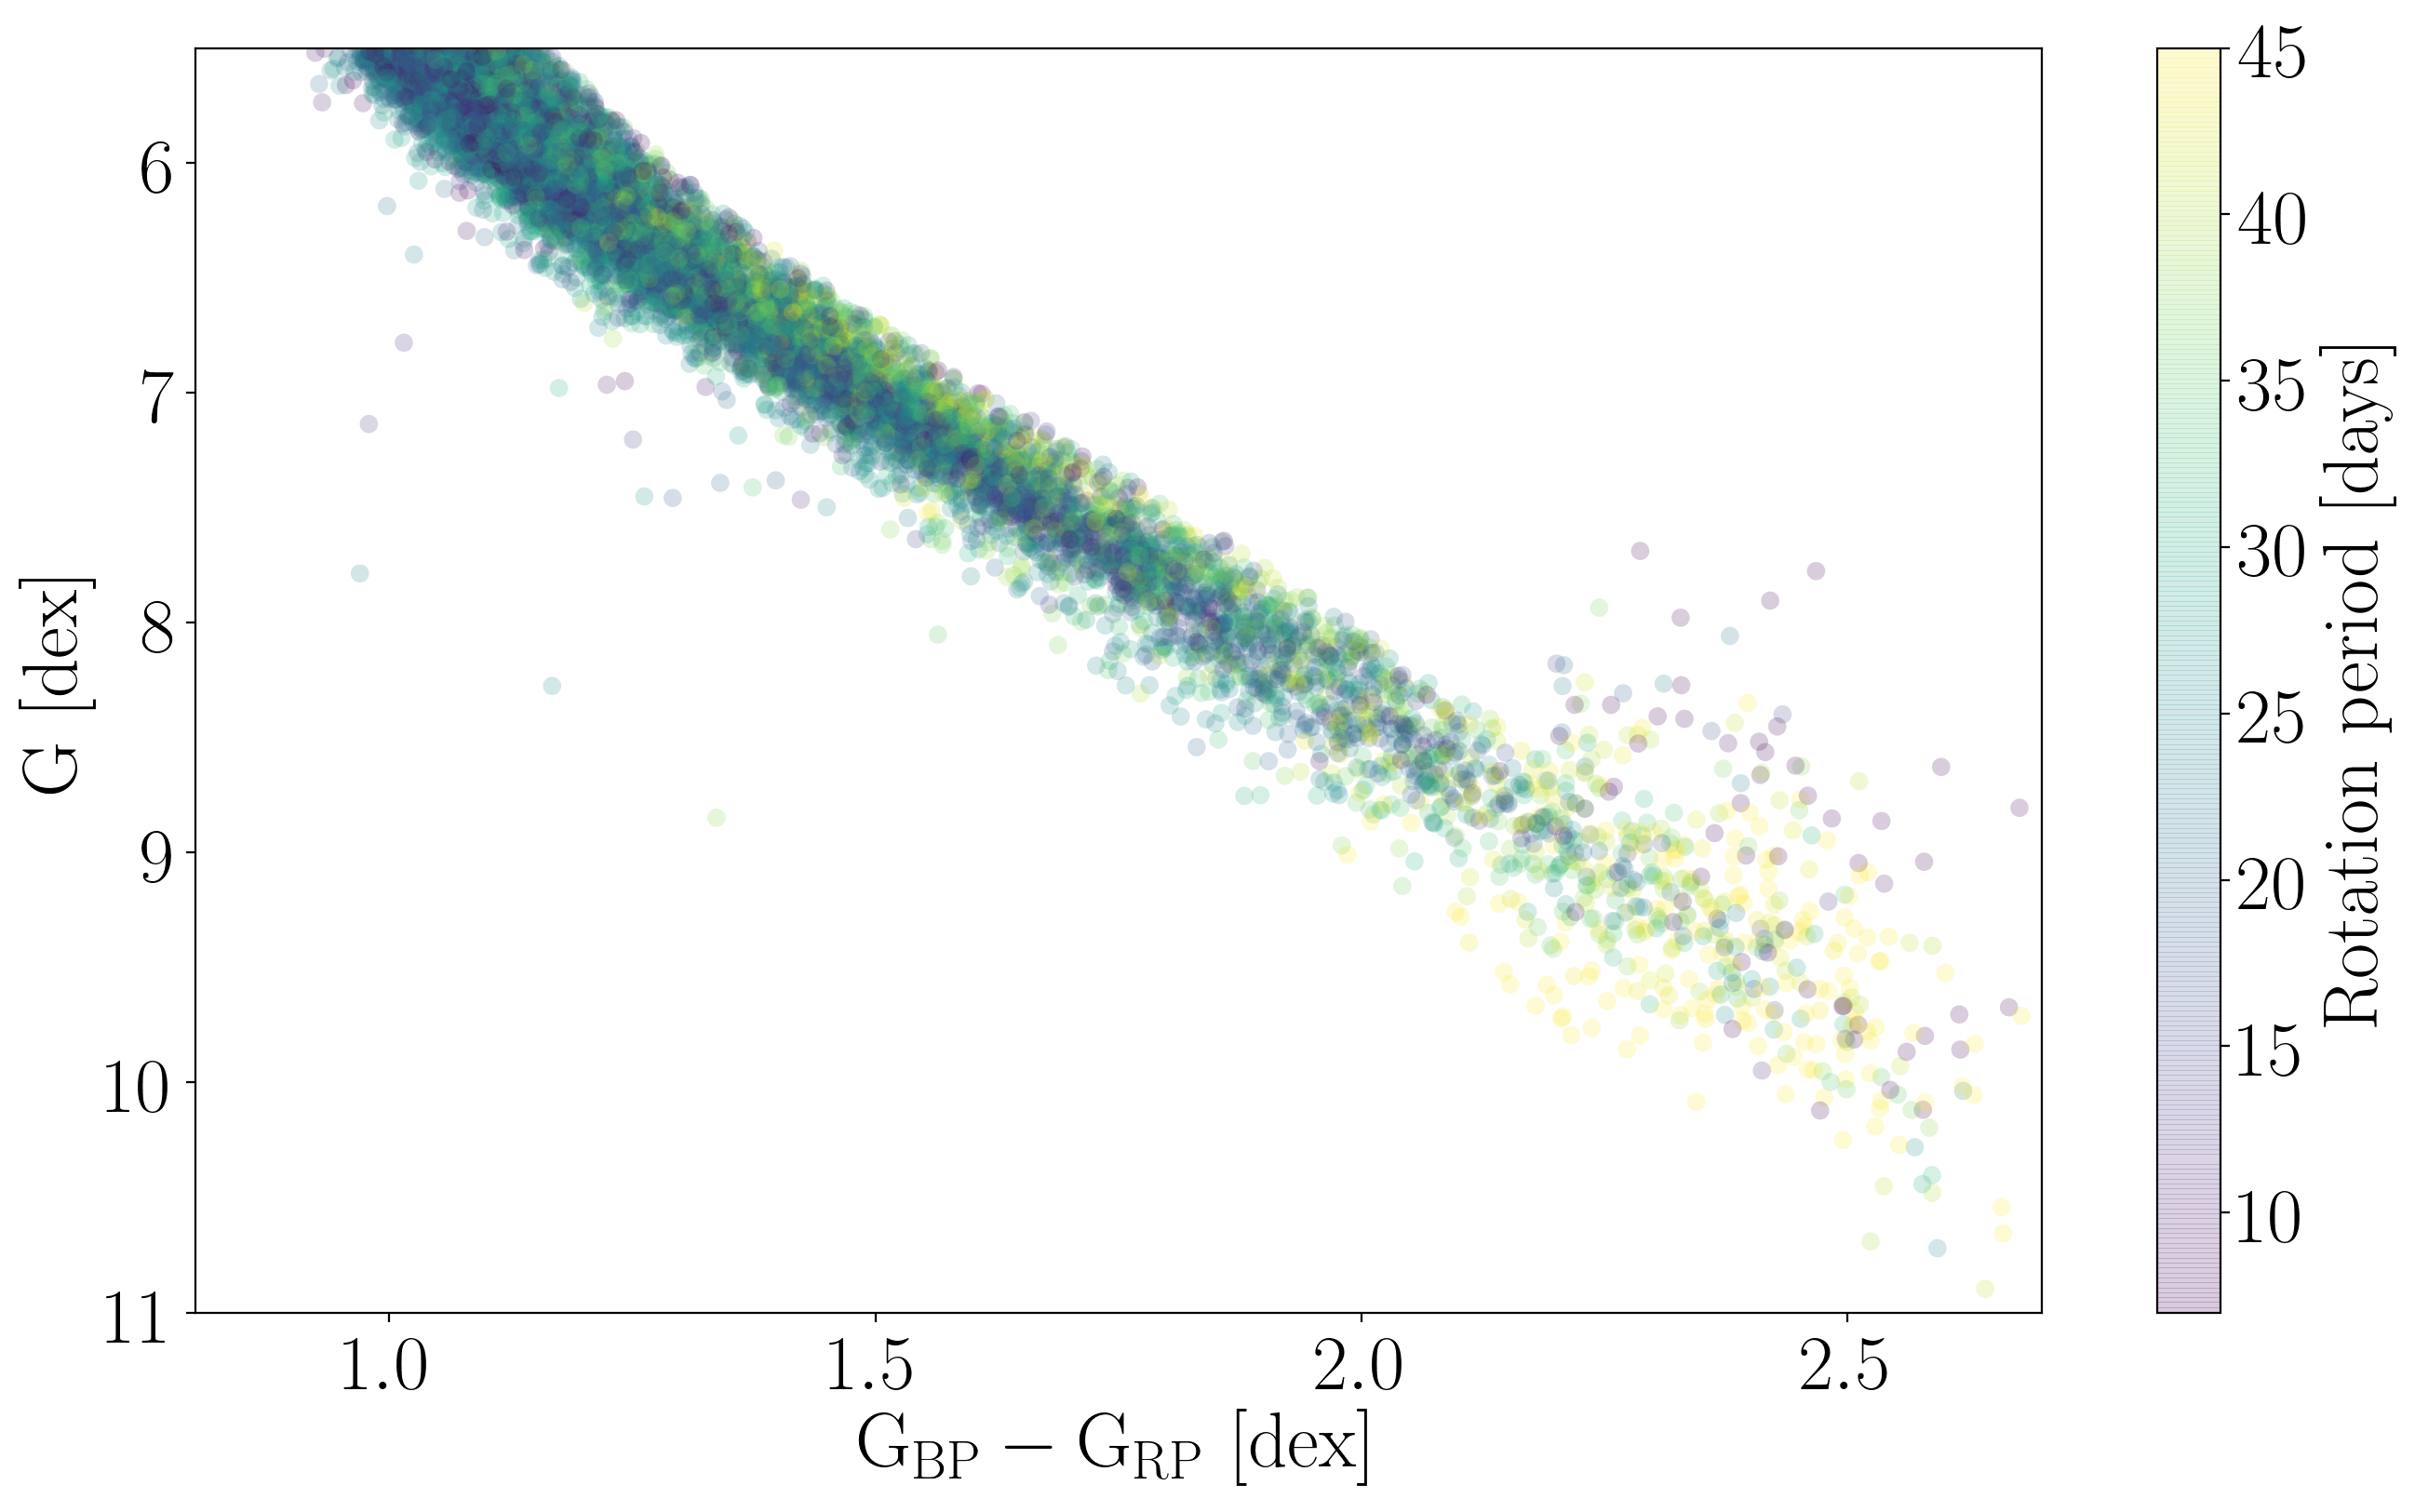

In [313]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.abs_G, vmin=7, vmax=45,
            c=df.Prot, s=50, alpha=.2, cmap="viridis", rasterized=True,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 5.5)
plt.xlim(.8, 2.7);

plt.savefig("paper/prot_gradient.pdf")

Plot all McQuillan single dwarfs.

(34030, 11)


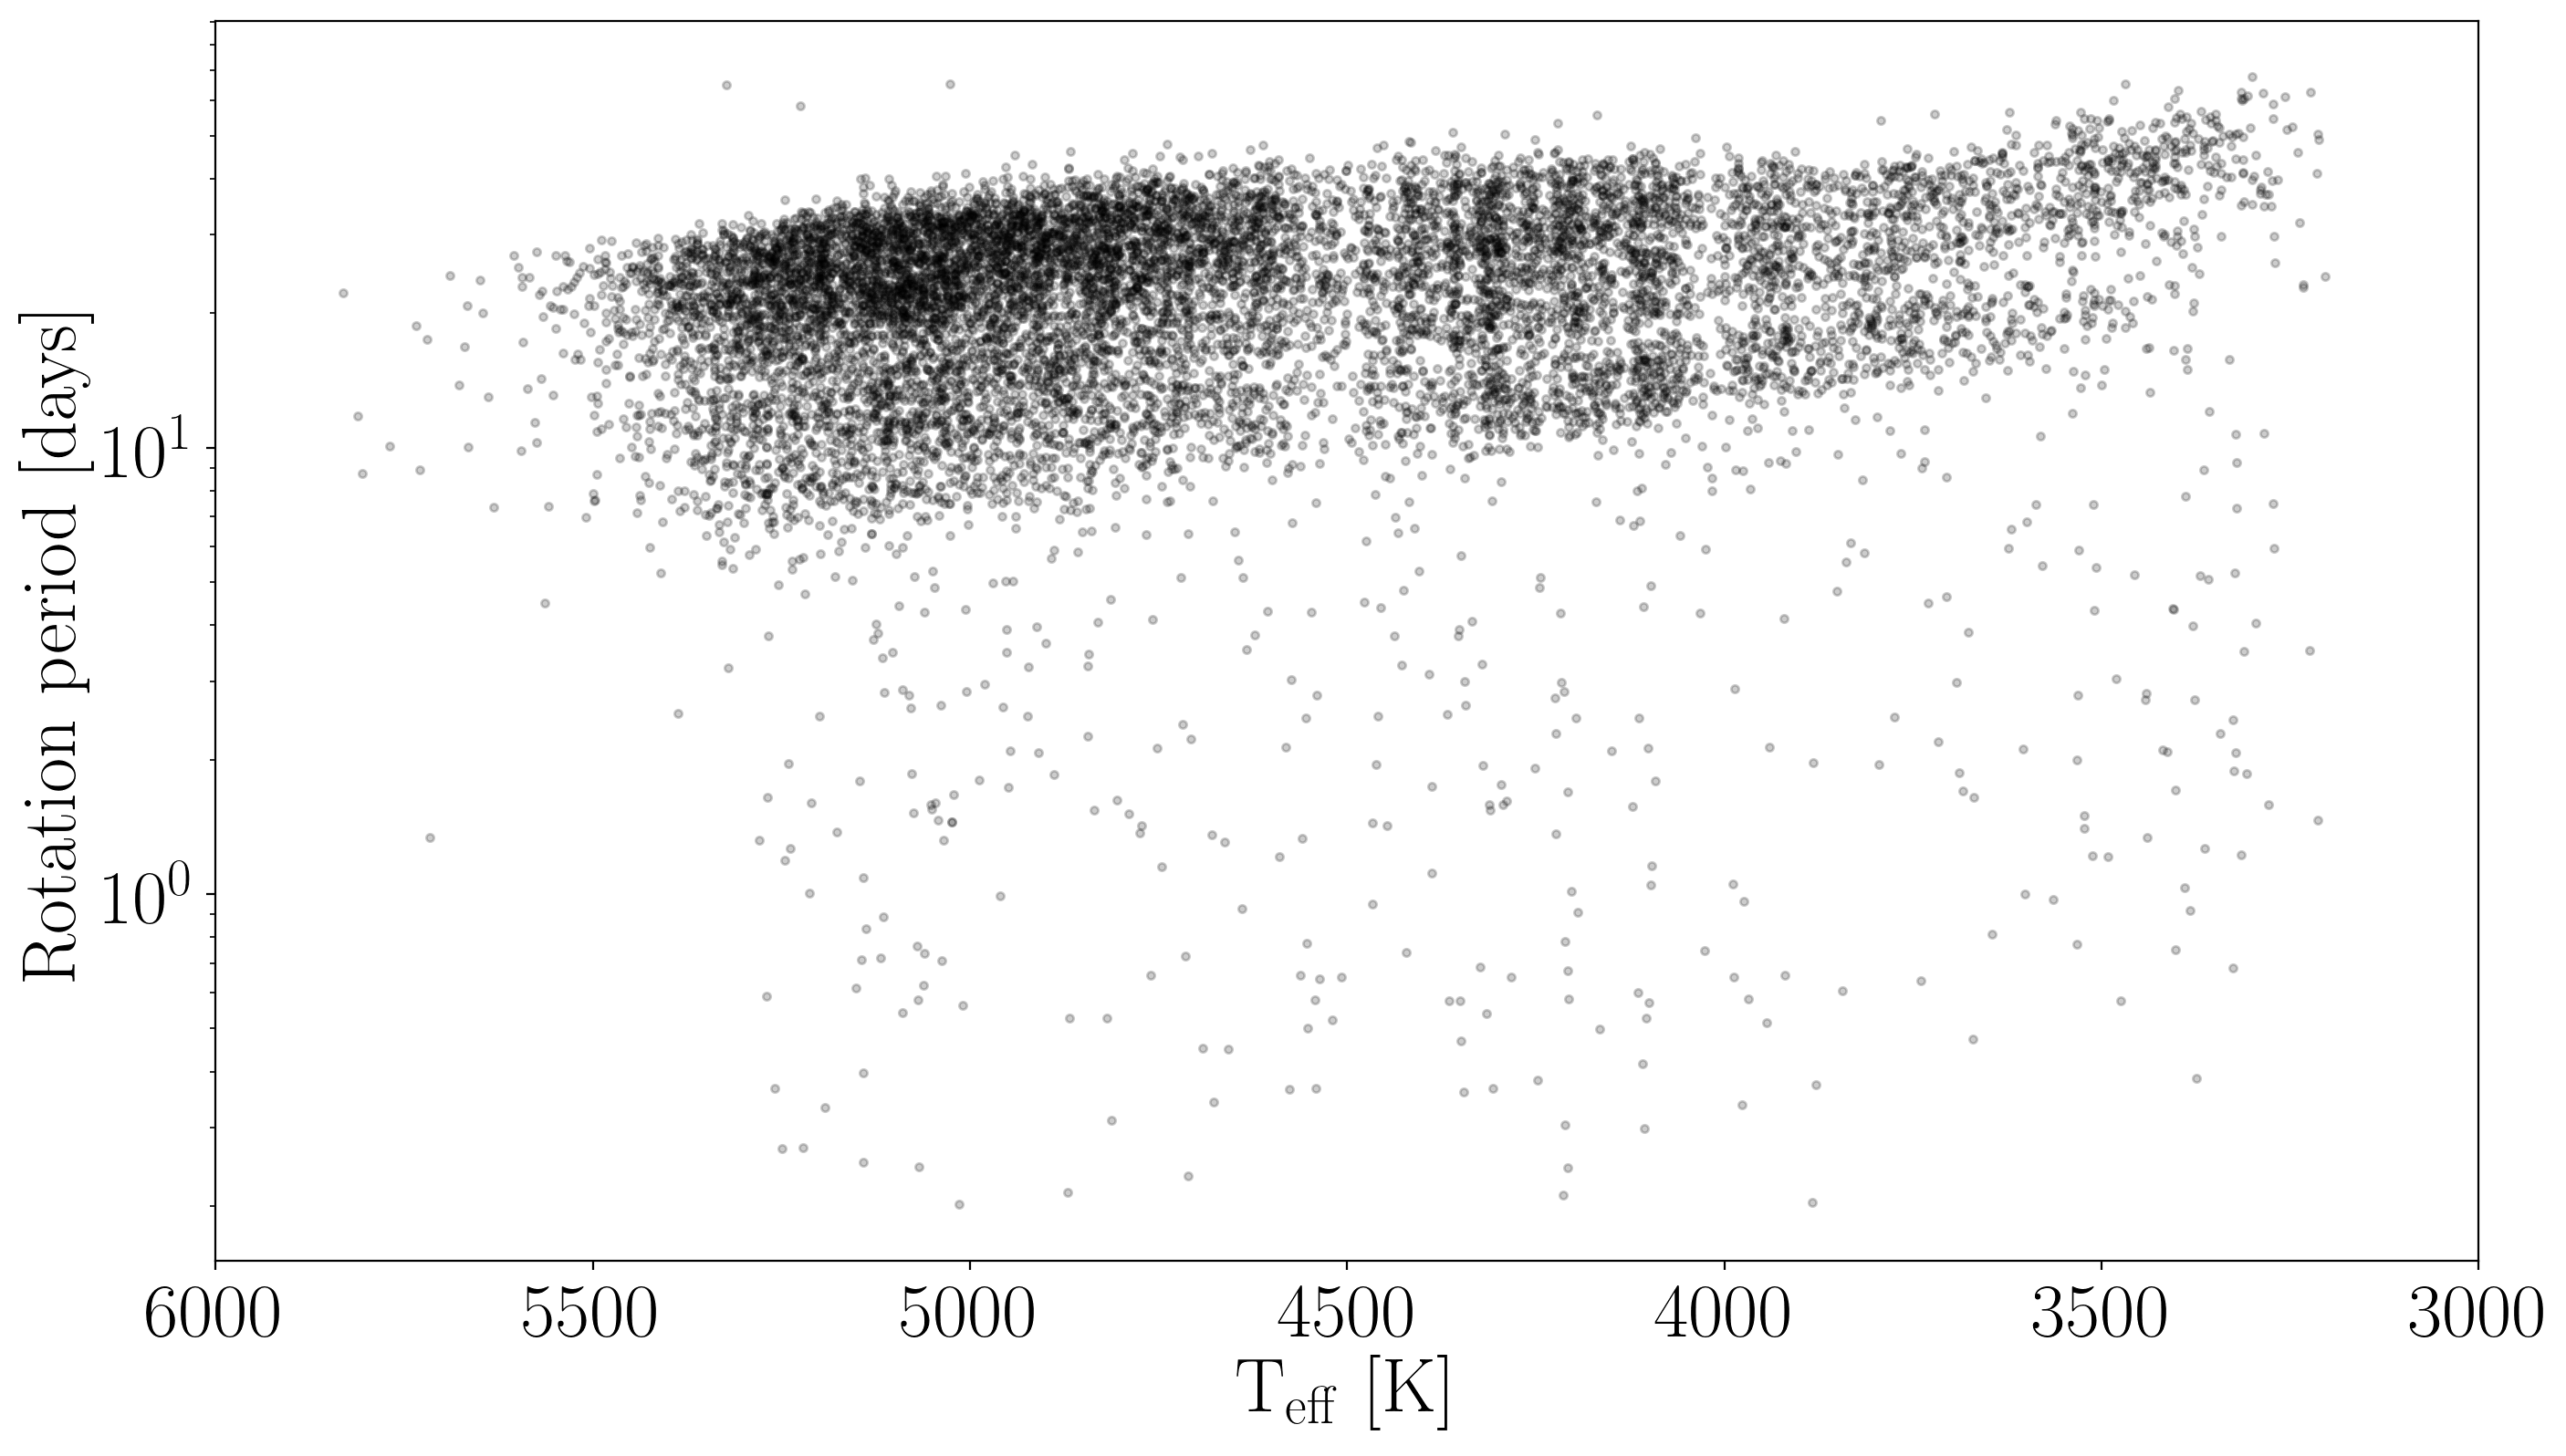

In [314]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(df.Teff, df.Prot, "k.", alpha=.2, zorder=0, rasterized=True)
plt.xlim(6000, 3000)
plt.yscale("log")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");
plt.savefig("paper/the_gap.pdf")
print(np.shape(mc))

Cut out stars with negative parallax and stars with low signal-to-noise.

In [315]:
m = df.parallax.values > 0.
m &= df.parallax.values/df.parallax_error.values > 10.
df = df.iloc[m]

# m = gaia_mc.Teff.values < 4800
# gaia_mc_cool = gaia_mc.iloc[m]
# gaia_mc_hot = gaia_mc.iloc[~m]

Calculate velocities.

In [166]:
from calc_velocities import calc_vb

pmb_samples, vb_samples = calc_vb(df)
print(np.shape(pmb_samples))

(11869, 1000)


In [167]:
print(np.shape(vb_samples))
print(vb_samples[0, 0])

(11869, 1000)
-0.9257564782365716


In [168]:
pmb, vb = np.median(pmb_samples, axis=1), np.median(vb_samples, axis=1)
pmb_err, vb_err = np.std(pmb_samples, axis=1), np.std(vb_samples, axis=1)
pmb_errp = np.percentile(pmb_samples, 84, axis=1) - pmb
pmb_errm = pmb - np.percentile(pmb_samples, 16, axis=1)
vb_errp = np.percentile(vb_samples, 84, axis=1) - vb
vb_errm = vb - np.percentile(vb_samples, 16, axis=1)

In [169]:
df["vb"] = vb
df["vb_err"] = vb_err

In [170]:
# import astropy.units as u
# from astropy.coordinates import ICRS
# from astropy.coordinates import Galactic

# i = 0
# icrs = ICRS(ra=gaia_mc.ra.values*u.degree,
#             dec=gaia_mc.dec.values*u.degree,
#             distance=1./(gaia_mc.parallax.values*1e-3)*u.pc,
#             pm_ra_cosdec=gaia_mc.pmra.values*u.mas/u.yr,
#             pm_dec=gaia_mc.pmdec.values*u.mas/u.yr)
# vels = icrs.transform_to(Galactic)
# print(vels)
# # vels.pm_b
# # pm_b = np.array(vels.pm_b.value)
# # gaia_mc_cool["pm_b"] = pm_b

Calculate v_ra, v_dec and v_b

In [171]:
import astropy.coordinates as coord
import astropy.units as u
d = coord.Distance(parallax=df.parallax.values * u.mas)
vra = (df.pmra.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
vdec = (df.pmdec.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())

c = coord.SkyCoord(ra=df.ra.values*u.deg, dec=df.dec.values*u.deg, distance=d, 
                   pm_ra_cosdec=df.pmra.values*u.mas/u.yr,
                   pm_dec=df.pmdec.values*u.mas/u.yr)
gal = c.galactic
v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles())

df["v_b"] = v_b.value
df["v_ra"] = vra.value
df["v_dec"] = vdec.value

Calculate actions for stars with RVs.

In [172]:
mrv = df.radial_velocity.values != 0.00
print(len(df.radial_velocity[mrv]), "stars in McQuillan with Gaia RVs")

472 stars in McQuillan with Gaia RVs


In [173]:
import actions as ac
from tqdm import trange

jz = np.ones(len(df.ra.values))*np.nan
for i in trange(len(df.ra.values)):
    if df.radial_velocity.values[i] != 0.00:
        try:
            R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, Lz, Jz = ac.action(
                df.ra.values[i], df.dec.values[i],
                1./df.parallax.values[i], 
                df.pmra.values[i], df.pmdec.values[i],
                df.radial_velocity.values[i])
            jz[i] = Jz
        except:
            UnboundError

df["jz"] = jz

100%|██████████| 11869/11869 [00:23<00:00, 511.54it/s]


Still to do: calculate action uncertainties, e.g.:

In [174]:
# def action_with_err(ra_dec, dec_deg, parallax_mas, pmra_masyr, pmdec_masyr, rv_kms, rv_err, cov):
#     """
#     Calculate actions with uncertainties, given a covariance matrix.
    
#     Args:
#         ra_deg
#         dec_deg
#         parallax_mas
#         pmra_masyr
#         pmdec_masyr
#         rv_kms
#         rv_err
#         cov
        
#     cov = [[ra_err**2        ra_dec_corr       ra_parallax_corr    ra_pmra_corr       ra_pmdec_corr]
#            [ra_dec_corr      dec_err**2        dec_parallax_corr   dec_pmra_corr      dec_pmdec_corr]
#            [ra_parallax_corr dec_parallax_corr parallax_err**2     parallax_pmra_corr parallax_pmdec_corr]
#            [ra_pmra_corr     dec_pmra_corr     parallax_pmra_corr  pmra_err**2        pmra_pmdec_corr]
#            [ra_pmdec_corr    dec_pmdec_corr    parallax_pmdec_corr pmra_pmdec_corr    pmdec_err**2]]
#     """

Save Gaia-Mcquillan crossmatch with velocities to csv.

In [175]:
df.to_csv("gaia_mc.csv")

If you want to make this smaller, the Gaia columns to keep are:

In [ ]:
mini_gaia = pd.DataFrame(dict({"source_id": gaia.source_id,
                               "kepid": gaia.kepid,
                               "ra": gaia.ra, "ra_error": gaia.ra_error,
                               "dec": gaia.dec, "dec_error": gaia.dec_error,
                               "parallax": gaia.parallax,
                               "parallax_error": gaia.parallax_error,
                               "pmra": gaia.pmra, "pmra_error": gaia.pmra_error,
                               "pmdec": gaia.pmdec, "pmdec_error": gaia.pmdec_error,
                               "ra_dec_corr": gaia.ra_dec_corr,
                               "ra_parallax_corr": gaia.ra_parallax_corr,
                               "ra_pmra_corr": gaia.ra_pmra_corr,
                               "ra_pmdec_corr": gaia.ra_pmdec_corr,
                               "dec_parallax_corr": gaia.dec_parallax_corr,
                               "dec_pmra_corr": gaia.dec_pmra_corr,
                               "dec_pmdec_corr": gaia.dec_pmdec_corr,
                               "parallax_pmra_corr": gaia.parallax_pmra_corr,
                               "parallax_pmdec_corr": gaia.parallax_pmdec_corr,
                               "pmra_pmdec_corr": gaia.pmra_pmdec_corr,
                               "radial_velocity": gaia.radial_velocity,
                               "radial_velocity_error": gaia.radial_velocity_error,
                               "G": gaia.phot_g_mean_mag,
                               "bp": gaia.phot_bp_mean_mag,
                               "rp": gaia.phot_rp_mean_mag,
                               "jmag": gaia.jmag,
                               "hmag": gaia.hmag,
                               "kmag": gaia.kmag
                              }))

Let's try running stardate on one of these stars.

In [34]:
import stardate as sd

Only use metallicities if they're spectroscopic.

In [35]:
i = 0
if df["n_[Fe/H]i"].values[i] == "SPE":
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "feh": (df["[Fe/H]i"].values[i], .05),
                  "parallax": (df.plx[i].values*1e3, df.plxe.values[i]*1e3)}
else:
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "parallax": (df.plx.values[i]*1e3, df.plxe.values[i]*1e3)}
    
print(iso_params)
print(df.Prot.values[i], df.Av.values[i], df.Av_errm.values[i])

prot, prot_err = df.Prot.values[i], df.Prot.values[i]*.05
star = sd.Star(iso_params, prot=prot, prot_err=prot_err,
               Av=df.Av.values[i], Av_err=df.Av_std.values[i],
               savedir="posteriors", filename="test")

{'g': (16.087088578099998, 0.0203150148217), 'r': (15.2187902098, 0.020088848135900002), 'J': (13.652000000000001, 0.026000000000000002), 'H': (13.099, 0.025), 'K': (13.003, 0.026000000000000002), 'parallax': (1.7670000000000001, 0.0248)}
13.765 0.23306999223679303 0.00932279805511238


In [36]:
star.fit(max_n=10000, thin_by=100)

100%|██████████| 10000/10000 [01:38<00:00, 101.14it/s]


In [37]:
from stardate import load_samples, read_samples

# Load the samples.
flatsamples, samples, prior_samples, posterior_samples = load_samples("posteriors/test.h5", burnin=50)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

EEP_med  EEP_errm  EEP_errp   EEP_std      EEP_ml  age_med_gyr  \
0  281.692558  3.059793    3.2398  8.310309  281.140365     0.972628   

   age_errm  age_errp  age_std  age_ml_gyr  ...    distance_errm  \
0   0.08027  0.093708  0.58478    0.959946  ...         8.033859   

   distance_errp  distance_std_pc  distance_ml    Av_med  Av_errm   Av_errp  \
0       7.998642        21.331033   564.919469  0.232051  0.01011  0.010078   

     Av_std    Av_ml  index  
0  0.011117  0.23126      0  

[1 rows x 26 columns]

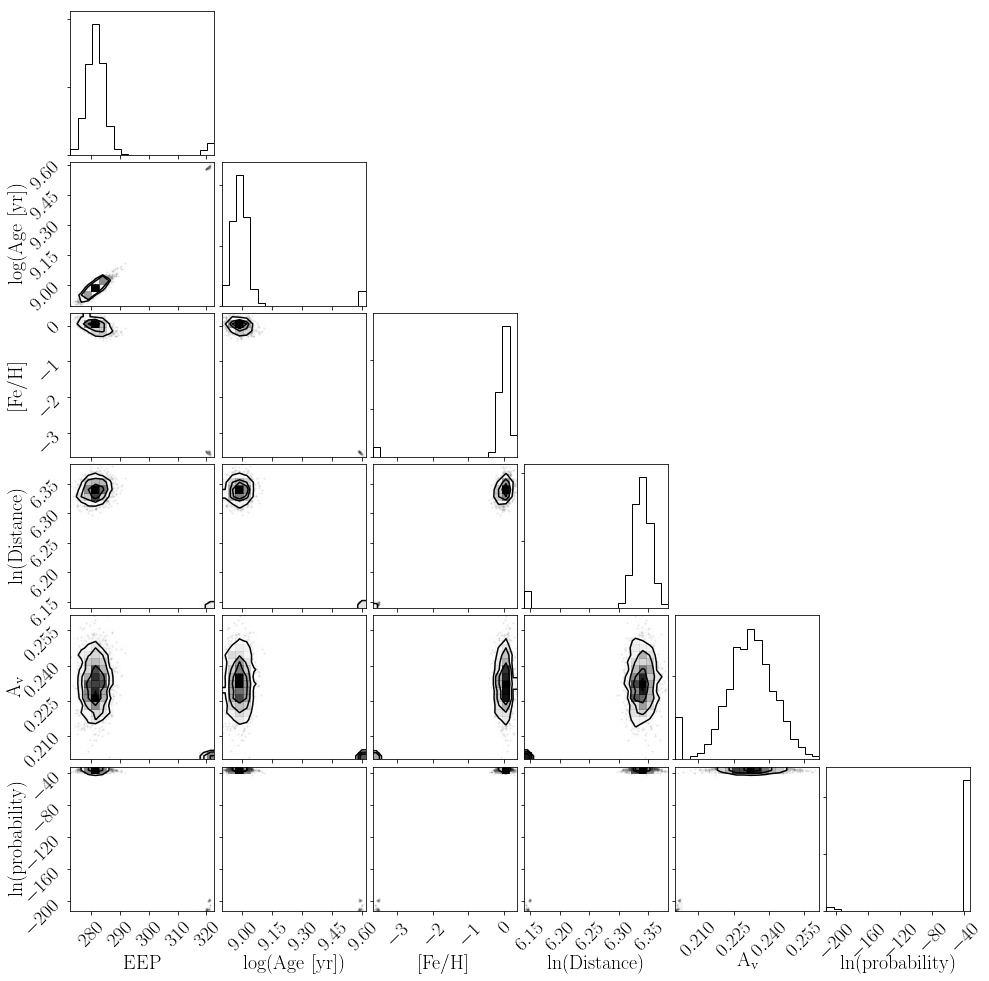

In [38]:
import corner

plotpar = {'axes.labelsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20}
plt.rcParams.update(plotpar)

labels = ["$\mathrm{EEP}$", "$\mathrm{log(Age~[yr])}$", 
          "$\mathrm{[Fe/H]}$", "$\mathrm{ln(Distance)}$",
          "$\mathrm{A_v}$", "$\mathrm{ln(probability)}$"]

corner.corner(flatsamples, labels=labels);